## HW3: Decision Tree, AdaBoost and Random Forest
In hw3, you need to implement decision tree, adaboost and random forest by using only numpy, then train your implemented model by the provided dataset. TA will use the on-hold test label to evaluate your model performance.

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling `sklearn.tree.DecisionTreeClassifier`

In [1]:
import numpy as np
import math
import random



## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 5 of hw3 slides](https://docs.google.com/presentation/d/1kIe_-YZdemRMmr_3xDy-l0OS2EcLgDH7Uan14tlU5KE/edit#slide=id.gd542a5ff75_0_15)

In [2]:
# Copy and paste your implementations right here to check your result
# (Of course you can add your classes not written here)
def gini(sequence):

    cls_count = {}
    for c in sequence:
        if c in cls_count.keys():
            cls_count[c] += 1
        else:
            cls_count[c] = 1
    
    Gini = 1.0
    for c in cls_count.keys():
        p = cls_count[c] / len(sequence)
        Gini -= p ** 2

    return Gini


def entropy(sequence):
    cls_count = {}
    for c in sequence:
        if c in cls_count.keys():
            cls_count[c] += 1
        else:
            cls_count[c] = 1

    Entropy = 0.0
    for c in cls_count.keys():
        p = cls_count[c] / len(sequence)
        Entropy -= p * math.log2(p)
    
    return Entropy

In [3]:
# 1 = class 1,
# 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])

In [4]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [5]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006402


## Load data
It is a binary classifiation dataset that classify if price is high or not for a cell phone, the label is stored in `price_range` column.

In [6]:
import pandas as pd

train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')

x_train = train_df.drop('price_range', axis=1)
x_test = val_df.drop('price_range', axis=1)

feature_names = x_train.columns.values

x_train = x_train.values
y_train = train_df['price_range'].values

x_test = x_test.values
y_test = val_df['price_range'].values

#print(train_df)


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the validation data. You should implement two arguments for the Decision Tree algorithm
1. **criterion**: The function to measure the quality of a split. Your model should support `gini` for the Gini impurity and `entropy` for the information gain. 
2. **max_depth**: The maximum depth of the tree. If `max_depth=None`, then nodes are expanded until all leaves are pure. `max_depth=1` equals to split data once


In [7]:
class Node():
    def __init__(self, left_cls=None, right_cls=None, feature=None, threshold=None, left=None, right=None, is_leaf=True, depth=0):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.is_leaf = is_leaf
        self.depth = depth
        self.left_cls = left_cls
        self.right_cls = right_cls
    
    def fillin(self, feature, threshold, is_leaf, left=None, right=None):
        self.feature = feature
        self.threshold = threshold
        self.is_leaf = is_leaf
        self.left = left
        self.right = right


In [8]:
class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None):
        self.criterion = criterion
        self.max_depth = max_depth
        self.root = Node()

    def fit(self, x_data, y_data, node=None, indices=None, max_features=None):
        
        # indices -> the indices of data that the sample picks 
        # features -> the indices of feature that the node picks
        
        if node is None:
            node = self.root

        if indices is None:
            indices = np.array([i for i in range(x_data.shape[0])])

        if max_features == x_data.shape[1] or max_features is None:
            features = np.array([i for i in range(x_data.shape[1])])
        else:
            features = np.random.choice(x_data.shape[1], max_features, replace=False)

        y_part = [y_data[idx] for idx in indices]
        pure = self.check_pure(y_part)

        if pure == 0:
            node.left_cls, node.right_cls = 0, 0
            return
        elif pure == 1:
            node.left_cls, node.right_cls = 1, 1
            return
        
        # find feature and threshold
        feature, threshold = self.find_threshold(x_data, y_data, indices, features)

        # fill in information of node and split data
        is_leaf = node.depth == self.max_depth-1 or feature == -1
        left_node, right_node = None, None
        
        if not is_leaf:
            left_node = Node(depth=node.depth+1)
            right_node = Node(depth=node.depth+1)
        
        
        left_indices, right_indices = self.split(x_data, feature, threshold, indices)
        node.fillin(feature, threshold, is_leaf, left_node, right_node)

        # if leaf -> check the class of right and left
        if not is_leaf:
            self.fit(x_data, y_data, node=left_node, indices=left_indices, max_features=max_features)
            self.fit(x_data, y_data, node=right_node, indices=right_indices, max_features=max_features)
        else:

            left_y = np.array([y_data[idx] for idx in left_indices])
            right_y = None

            if right_indices is not None:
                right_y = np.array([y_data[idx] for idx in right_indices])
                
            if self.check_class(left_y):
                node.left_cls = 1
            else:
                node.left_cls = 0
            
            if right_y is not None and self.check_class(right_y):
                node.right_cls = 1
            else:
                node.right_cls = 0

    def predict(self, x_data):
        y_pred = np.zeros(shape=x_data.shape[0])

        for i in range(x_data.shape[0]):
            y_pred[i] = self.traverse(x_data[i], self.root)
        
        return y_pred

    ###################################################
    # check what class is for the leaf node
    ###################################################
    def check_class(self, y_data):
        count = 0
        for c in y_data:
            if c == 0:
                count += 1

        if count > y_data.shape[0] - count:
            return 0
        else:
            return 1

    ##################################################
    # check purity
    ##################################################

    def check_pure(self, y_data):
        count = 0
        y_data = np.array(y_data)
        for c in y_data:
            if c == 0:
                count += 1

        if count == y_data.shape[0]:
            return 0
        elif count == 0:
            return 1
        else:
            return -1

    #################################################
    # find_threshold
    #################################################
    def find_threshold(self, x_data, y_data, indices, features):
        min_crit = 10.0
        feature = -1
        threshold = 0
        
        # run all features and unique values to find the threshold and feature
        for col in features:
            values = x_data[:, col] 
            values = np.unique(values)

            if len(values) == 1:
                continue

            values = values[:-1]
            
            for value in values:
                
                left_indices = np.array([idx for idx in indices if x_data[idx][col] <= value])
                right_indices = np.array([idx for idx in indices if x_data[idx][col] > value])

                left = np.array([y_data[idx] for idx in left_indices])
                right = np.array([y_data[idx] for idx in right_indices])

                total = len(left_indices) + len(right_indices)

                if self.criterion == 'gini':
                    crit_value = len(left_indices) / total * gini(left) + len(right_indices) / total * gini(right)
                else:
                    crit_value = len(left_indices) / total * entropy(left) + len(right_indices) / total * entropy(right)

                if crit_value < min_crit:
                    min_crit = crit_value
                    feature = col
                    threshold = value

        #print(min_crit)
        #print("threshold: {th}  feature: {f}".format(th=threshold, f=feature))
        #print(feature, threshold)    
        return (feature, threshold)

    ###############################################
    # split dataset
    ###############################################
    def split(self, x_data, feature, threshold, indices):
        if feature == -1:
            return indices, None

        left_indices = np.array([idx for idx in indices if x_data[idx][feature] <= threshold])
        right_indices = np.array([idx for idx in indices if x_data[idx][feature] > threshold])

        return left_indices, right_indices

    ###############################################
    # traverse during predict
    ###############################################
    def traverse(self, x, node):
        if node.feature is None or node.feature == -1:
            return node.left_cls
        elif node.is_leaf:
            if x[node.feature] <= node.threshold:
                return node.left_cls
            elif x[node.feature] > node.threshold:
                return node.right_cls

        if node.left is not None and x[node.feature] <= node.threshold:
            return self.traverse(x, node.left)
        elif node.right is not None and x[node.feature] > node.threshold:
            return self.traverse(x, node.right)
    

In [9]:
def Accuracy(y_data, y_pred):
    correct = 0
    
    for i in range(len(y_data)):
        if y_data[i] == y_pred[i]:
            correct += 1
    
    acc = correct / len(y_data)
    return acc

### Question 2.1
Using `criterion=gini`, showing the accuracy score of validation data by `max_depth=3` and `max_depth=10`, respectively.


In [10]:
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth10 = DecisionTree(criterion='gini', max_depth=10)

clf_depth3.fit(x_train, y_train)
clf_depth10.fit(x_train, y_train)

KeyboardInterrupt: 

In [17]:
y_pred3 = clf_depth3.predict(x_test)
#print(y_pred3)
acc3 = Accuracy(y_test, y_pred3)
print("Accuracy with depth 3: {}".format(acc3))


y_pred10 = clf_depth10.predict(x_test)
acc10 = Accuracy(y_test, y_pred10)
print("Accuracy with depth 10: {}".format(acc10))

Accuracy with depth 3: 0.9166666666666666
Accuracy with depth 10: 0.9366666666666666


### Question 2.2
Using `max_depth=3`, showing the accuracy score of validation data by `criterion=gini` and `criterion=entropy`, respectively.


In [68]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_entropy = DecisionTree(criterion='entropy', max_depth=3)

clf_gini.fit(x_train, y_train)
clf_entropy.fit(x_train, y_train)

In [69]:
y_pred_gini = clf_gini.predict(x_test)
acc_gini = Accuracy(y_test, y_pred_gini)
print("Accuracy with gini: {}".format(acc_gini))


y_pred_entropy = clf_entropy.predict(x_test)
acc_entropy = Accuracy(y_test, y_pred_entropy)
print("Accuracy with entropy: {}".format(acc_entropy))

Accuracy with gini: 0.9166666666666666
Accuracy with entropy: 0.93


- Note: Your decisition tree scores should over **0.7**. It may suffer from overfitting, if so, you can tune the hyperparameter such as `max_depth`
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the **counts of feature used** for building tree without normalize the importance. Take the figure below as example, outlook feature has been used for splitting for almost 50 times. Therefore, it has the largest importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

{'ram': 9, 'px_height': 9, 'fc': 2, 'battery_power': 19, 'px_width': 5, 'm_dep': 2, 'mobile_wt': 1}


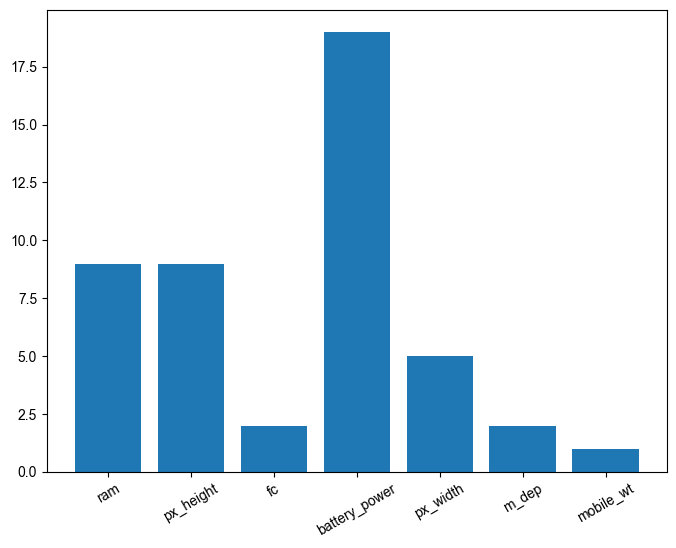

In [70]:
# traverse the tree and count the features
def calc_feature(node):
    feature_dict = {}

    if node.feature == -1 or node.feature is None:
        return feature_dict

    feature_dict[feature_names[node.feature]] = 1

    if node.left is not None:
        left = calc_feature(node.left)
        for key in left.keys():
            if key in feature_dict.keys():
                feature_dict[key] += left[key]
            else:
                feature_dict[key] = left[key]

    if node.right is not None:
        right = calc_feature(node.right)
        for key in right.keys():
            if key in feature_dict.keys():
                feature_dict[key] += right[key]
            else:
                feature_dict[key] = right[key]
    
    return feature_dict

feature_dict = calc_feature(clf_depth10.root)
print(feature_dict)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
plt.bar(feature_dict.keys(), feature_dict.values())
plt.xticks(rotation=30)
sns.set()
plt.show()


## Question 4
implement the AdaBooest algorithm by using the CART you just implemented from question 2 as base learner. You should implement one arguments for the AdaBooest.
1. **n_estimators**: The maximum number of estimators at which boosting is terminated

In [8]:
class WeakClassifier():
    def __init__(self, cart=None, weight=None):
        self.weight = weight
        self.cart = cart

In [9]:
class AdaBoost():
    def __init__(self, n_estimators, depth=1):
        self.n_estimators = n_estimators
        self.classifiers = []
        self.depth = depth

    def fit(self, x_data, y_data):
        weight = np.ones(shape=(x_data.shape[0]))
        weight /= x_data.shape[0]  # initialize weight

        for _ in range(self.n_estimators):
            cart = DecisionTree(criterion='gini', max_depth=self.depth)
            weak_clf = WeakClassifier(cart=cart)

            # sample new dataset depends on the weight
            indices = np.random.choice(x_data.shape[0], x_data.shape[0], replace=True, p=weight)

            x_samples = x_data[indices]
            y_samples = y_data[indices]

            cart.fit(x_samples, y_samples)
            y_pred = cart.predict(x_data)

            error = 0.0
            for i in range(len(y_data)):
                error += weight[i] * (y_data[i] != y_pred[i])
            
            # alpha
            weak_clf.weight = (1/2) * np.log((1-error)/error)

            # update weight of data
            for i in range(len(weight)):
                weight[i] = weight[i] * np.exp(-weak_clf.weight * (2*y_data[i]-1) * (2*y_pred[i]-1))

            weight /= np.sum(weight)
            self.classifiers.append(weak_clf)

    def predict(self, x_data):
        result = np.zeros(shape=x_data.shape[0])

        for clf in self.classifiers:
            y_pred = clf.cart.predict(x_data)
            # the predictions are 0 and 1 -> transfer to -1 and 1
            y_pred = 2 * y_pred - 1
            for i in range(len(result)):
                result[i] += clf.weight * y_pred[i]
        
        for i in range(len(result)):
            if result[i] >= 0:
                result[i] = 1
            else:
                result[i] = 0

        return result

### Question 4.1
Show the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [73]:
clf10 = AdaBoost(n_estimators=10)
clf10.fit(x_train, y_train)


In [74]:
y_pred_ada10 = clf10.predict(x_test)
acc_ada10 = Accuracy(y_test, y_pred_ada10)
print("Accuracy with n=10 : {}".format(acc_ada10))

Accuracy with n=10 : 0.9466666666666667


In [75]:
clf100 = AdaBoost(n_estimators=100)
clf100.fit(x_train, y_train)

In [76]:
y_pred_ada100 = clf100.predict(x_test)
acc_ada100 = Accuracy(y_test, y_pred_ada100)
print("Accuracy with n=100 : {}".format(acc_ada100))

Accuracy with n=100 : 0.97


## Question 5
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **n_estimators**: The number of trees in the forest. 
2. **max_features**: The number of random select features to consider when looking for the best split
3. **bootstrap**: Whether bootstrap samples are used when building tree


In [77]:
class RandomForest():
    def __init__(self, n_estimators, max_features, bootstrap=True, criterion='gini', max_depth=None):
        self.n_estimators = n_estimators
        self.max_features = math.ceil(max_features)
        self.bootstrap = bootstrap
        self.criterion = criterion
        self.max_depth = max_depth

        self.classifiers = []
        
    def fit(self, x_data, y_data):
        if self.max_depth is None:
            self.max_depth = x_data.shape[0]

        for _ in range(self.n_estimators):
            # sample from dataset
            if self.bootstrap:
                indices = np.random.choice(x_data.shape[0], x_data.shape[0], replace=True)
            else:
                indices = np.array([i for i in range(x_data.shape[0])])
            #print(type(self.max_features))
            
            clf = DecisionTree(criterion='gini', max_depth=self.max_depth)
            #print(indices, features)
            clf.fit(x_data, y_data, indices=indices, max_features=self.max_features)

            self.classifiers.append(clf)

    def predict(self, x_data):
        result = np.zeros(shape=x_data.shape[0])

        for i in range(x_data.shape[0]):
            for clf in self.classifiers:
                pred_cls = clf.traverse(x_data[i], clf.root)
        
                if pred_cls == 1:
                    result[i] += 1
                else:
                    result[i] += -1
        
        for i in range(len(result)):
            if result[i] >= 0:
                result[i] = 1
            else:
                result[i] = 0
        
        return result
                


### Question 5.1
Using `criterion=gini`, `max_depth=None`, `max_features=sqrt(n_features)`, showing the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [78]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(x_train.shape[1]))

In [79]:
clf_10tree.fit(x_train, y_train)
pred_fore10 = clf_10tree.predict(x_test)
acc_fore10 = Accuracy(y_test, pred_fore10)
print("Accuracy of random forest n=10 : {}".format(acc_fore10))

Accuracy of random forest n=10 : 0.9433333333333334


In [80]:
clf_100tree.fit(x_train, y_train)
pred_fore100 = clf_100tree.predict(x_test)
acc_fore100 = Accuracy(y_test, pred_fore100)
print("Accuracy of random forest n=100 : {}".format(acc_fore100))

Accuracy of random forest n=100 : 0.95


### Question 5.2
Using `criterion=gini`, `max_depth=None`, `n_estimators=10`, showing the accuracy score of validation data by `max_features=sqrt(n_features)` and `max_features=n_features`, respectively.


In [81]:
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_all_features = RandomForest(n_estimators=10, max_features=x_train.shape[1])

- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

In [82]:
clf_random_features.fit(x_train, y_train)
clf_all_features.fit(x_train, y_train)

pred_rf = clf_random_features.predict(x_test)
acc_rf = Accuracy(y_test, pred_rf)
print("Accuracy of random feature: {}".format(acc_rf))

pred_af = clf_all_features.predict(x_test)
acc_af = Accuracy(y_test, pred_af)
print("Accuracy of all feature: {}".format(acc_af))

Accuracy of random feature: 0.93
Accuracy of all feature: 0.9466666666666667


### Question 6. Train and tune your model on a real-world dataset
Try you best to get higher accuracy score of your model. After parameter tuning, you can train your model on the full dataset (train + val).
- Feature engineering
- Hyperparameter tuning
- Implement any other ensemble methods, such as gradient boosting. Please note that you **can not** call any package. Also, only ensemble method can be used. Neural network method is not allowed to used.

In [11]:
def train_your_model(data):
    ## Define your model and training
    x_train = data.drop('price_range', axis=1)
    x_train = x_train.values
    y_train = data['price_range'].values

    model = AdaBoost(n_estimators=150)
    model.fit(x_train, y_train) 
    return model

In [18]:
frames = [train_df, val_df]
data_df = pd.concat(frames)
my_model = train_your_model(data_df)

In [ ]:
test_df = pd.read_csv('x_test.csv')
x_test = test_df.values

In [ ]:
y_pred = my_model.predict(x_test)
np.save('y_pred.npy', y_pred)

In [ ]:
assert y_pred.shape == (500, )

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 

### DO NOT MODIFY CODE BELOW

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score
y_test = pd.read_csv('y_test.csv')['price_range'].values

print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

In [ ]:
def discrete_checker(score, thres, clf, name, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    
    if accuracy_score(y_test, y_pred) - thres >= 0:
        return score
    else:
        print(f"{name} failed")
        return 0


def patient_checker(score, thres, CLS, kwargs, name,
                    x_train, y_train, x_test, y_test, patient=10):
    while patient > 0:
        patient -= 1
        clf = CLS(**kwargs)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        
        if accuracy_score(y_test, y_pred) - thres >= 0:
            return score
    print(f"{name} failed")
    print("Considering the randomness, we will check it manually")
    return 0


def load_dataset():
    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv"
    df = pd.read_csv(
        file_url,
        names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
               "Viscera weight", "Shell weight", "Age"]
    )

    df['Target'] = (df["Age"] > 15).astype(int)
    df = df.drop(labels=["Age"], axis="columns")

    train_idx = range(0, len(df), 10)
    test_idx = range(1, len(df), 20)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    x_train = train_df.drop(labels=["Target"], axis="columns")
    feature_names = x_train.columns.values
    x_train = x_train.values
    y_train = train_df['Target'].values

    x_test = test_df.drop(labels=["Target"], axis="columns")
    x_test = x_test.values
    y_test = test_df['Target'].values
    return x_train, y_train, x_test, y_test, feature_names


score = 0

data = np.array([1, 2])
if abs(gini(data) - 0.5) < 1e-4:
    score += 2.5
else:
    print("gini test failed")

if abs(entropy(data) - 1) < 1e-4:
    score += 2.5
else:
    print("entropy test failed")

x_train, y_train, x_test, y_test, feature_names = load_dataset()

score += discrete_checker(5, 0.9337,
                          DecisionTree(criterion='gini', max_depth=3),
                          "DecisionTree(criterion='gini', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9036,
                          DecisionTree(criterion='gini', max_depth=10),
                          "DecisionTree(criterion='gini', max_depth=10)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9096,
                          DecisionTree(criterion='entropy', max_depth=3),
                          "DecisionTree(criterion='entropy', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

print("*** We will check your result for Question 3 manually *** (5 points)")

score += patient_checker(
    7.5, 0.91, AdaBoost, {"n_estimators": 10},
    "AdaBoost(n_estimators=10)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    7.5, 0.87, AdaBoost, {"n_estimators": 100},
    "AdaBoost(n_estimators=100)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 10, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=10, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 100, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=100, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.92, RandomForest,
    {"n_estimators": 10, "max_features": x_train.shape[1]},
    "RandomForest(n_estimators=10, max_features=n_features)",
    x_train, y_train, x_test, y_test
)

print("*** We will check your result for Question 6 manually *** (20 points)")
print("Approximate score range:", score, "~", score + 25)
print("*** This score is only for reference ***")